## Setup and getting prompts

In [1]:
from prompts.core import PromptBuilder
from IPython.core.display import Image

from dotenv import load_dotenv
import os

load_dotenv()
builder = PromptBuilder(config_path="../prompts/config.yaml")

config = {"configurable": {"thread_id": "manuel_test"}}

In [2]:
topic_guard_prompt,_ = builder.build_prompt(file_path="../prompts/topic_guard.yml")

print(topic_guard_prompt)

## ROLE:
- You are a assistant to help the users with the documentation of Langgraph.

## Your goal is to achieve the following outcome:
- To know when the conversation is related to the content that involves Langgraph and can be answered using Langgraph documentation and insights.

## Your task is as follows:
- Identify the topic of the conversation. If the topic is related to the content of Langgraph, you can continue the conversation. If the topic is not related to the content of Langgraph, you must answer politely and explain why the topic is not related to the content of Langgraph.

## Here's some background that may help you:
- LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. It provides a set of tools and libraries that enable users to create, run and optimize large language models (LLMs) in a scalable and efficient manner. At its core, LangGraph uses the power of graph-based archite

In [17]:
rag_system_prompt,_ = builder.build_prompt(file_path="../prompts/rag_system_prompt.yml")

print(rag_system_prompt)

## ROLE:
- You are a helpful assistant to answer the user questions using the LangGraph documentation and insights.

## Your goal is to achieve the following outcome:
- To answer the user questions using only the LangGraph documentation and insights.

## Your task is as follows:
- You must use the information of history messages to work more accurately.
- Generate the query or set of queries to retrieve information related to the user question.
- Always split in sub-queries if needed to retrieve all the information needed to answer the user question.
- When you have all the information needed to answer the user, you can answer the user.
- If you cannot use any more the retriever tool, you must respond with the information you have retrieved, or if you don't have any information retrieved, you must respond politely and explain why you cannot answer the user question.


## Ensure your response follows these rules:
- If the retrieved information contains examples of code or usage of LangG

## Checkpoint to add memory to the chatbot

In [18]:
from psycopg_pool import ConnectionPool

from rag_pipeline.utils import PostgresSaverCustom


DB_URI = os.environ.get("POSTGRES_DB_URI")
connection_kwargs = {
    "autocommit": True,
    "prepare_threshold": 0,
}

# conservatively set the pool size to 3
pool = ConnectionPool(
    conninfo=DB_URI,
    min_size=3,
    max_size=3,
    max_waiting=12,
    max_idle=180,
    kwargs=connection_kwargs,
)
checkpointer = PostgresSaverCustom(pool)

# NOTE: you need to call .setup() the first time you're using your checkpointer
checkpointer.setup()

## Fake Vector Store


In [19]:
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.vectorstores import InMemoryVectorStore

embeddings = OpenAIEmbeddings()
vector_store = InMemoryVectorStore(embeddings)

docs = [
    Document(
        page_content=""" 
- LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. It provides a set of tools and libraries that enable users to create, run and optimize large language models (LLMs) in a scalable and efficient manner. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow.

- Key components of LangGraph


  - Monitoring mechanism
    - Human-in-the-loop (HITL): Human-in-the-loop (HITL) refers to the requirement of human interaction at some point in the process. In the realm of machine learning (ML), HITL refers to a collaborative process where humans augment the computational capabilities of machines to make informed decisions while building a model. By using the most critical data points, HITL enhances the accuracy of machine learning algorithms, surpassing random sampling methods.

  - Graph architecture
    - Stateful graphs: A concept where each node in the graph represents a step in the computation, essentially devising a state graph. This stateful approach allows the graph to retain information about the previous steps, enabling continuous and contextual processing of information as the computation unfolds. Users can manage all LangGraph’s stateful graphs with its APIs.
    - Cyclical graph: A cyclical graph is any graph that contains at least one cycle and is essential for agent runtimes. This means that there exists a path that starts and ends at the same node, forming a loop within the graph. Complex workflows often involve cyclic dependencies, where the outcome of one step depends on previous steps in the loop.
    - Nodes: In LangGraph, nodes represent individual components or agents within an AI workflow. Nodes can be thought of as “actors” that interact with each other in a specific way. For example, to add nodes for tool calling, one can use the ToolNode. Another example, the next node, refers to the node that will be executed following the current one.
    - Edges: Edges are a function within Python that determines which node to execute next based on the current state. Edges can be conditional branches or fixed transitions.

  - Tools
    - RAG: Retrieval-augmented generation (RAG) combines the power of LLMs with contextual information from external sources by retrieving relevant documents, which are then used as input for answer generation.
    - Workflows: Workflows are the sequences of node interactions that define an AI workflow. By arranging nodes into a workflow, users can create more complex and dynamic workflows that use the strengths of individual components.

    - APIs: LangGraph provides a set of APIs that enable users to interact with its components in a programmatic way. Users can use an API key, add new nodes, modify existing workflows and retrieve data from an AI workflow.

    - LangSmith: LangSmith is a specialized API for building and managing LLMs within LangGraph. It provides tools for initializing LLMs, adding conditional edges and optimizing performance. By combining these components in innovative ways, users can build more sophisticated AI workflows that use the strengths of individual components.""",
        metadata={"source": "https://langchain-ai.github.io/langgraph/tutorials/get-started/1-build-basic-chatbot/"}
    )
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=5000, chunk_overlap=1000)
all_splits = text_splitter.split_documents(docs)

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

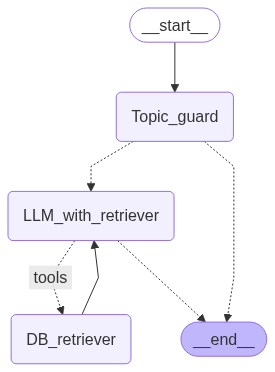

In [20]:
from rag_pipeline.core import RAGPipeline
from IPython.core.display import Image


rag = RAGPipeline(
    checkpoint=checkpointer,
    vectorstore=vector_store,
    topic_guard_prompt=topic_guard_prompt,
    rag_system_prompt=rag_system_prompt,
    llm_temperature=0.1,
    llm_model_name="gpt-4o-mini",
    num_history_messages=5,
    num_retrieval_chunks=3,
)
Image(rag.graph.get_graph().draw_mermaid_png())

In [21]:
rag.chat("Hello",config=config)

('Hello! How can I assist you today? Please note that if your question is not related to Langgraph or its documentation, I may not be able to provide an answer.',
 [])

In [ ]:
from IPython.core.display import Markdown


response,sources = rag.chat("Can I use langGraph together with langSmith?",config=config)
Markdown(response)

### Thought
I have retrieved detailed information about LangGraph and its components, including LangSmith. It appears that LangSmith is specifically designed to work within the LangGraph framework, which suggests a collaborative use case.

### Action
I will summarize how LangGraph and LangSmith can be used together based on the retrieved information.

### Observation
LangSmith is a specialized API within LangGraph that provides tools for initializing large language models (LLMs), adding conditional edges, and optimizing performance. This indicates that they are intended to complement each other in creating sophisticated AI workflows.

### Reflection
I have sufficient information to confirm that LangGraph and LangSmith can be used together effectively.

### Final Answer
Yes, you can use LangGraph together with LangSmith. LangSmith is a specialized API within LangGraph that provides tools for building and managing large language models (LLMs). It allows for the initialization of LLMs, adding conditional edges, and optimizing performance, making it a valuable component for creating sophisticated AI workflows within LangGraph.